# Welcome to the cooltools visualization notebook!


Visualization is a crucial part of analyzing large-scale datasets. Before performing analyses of new Hi-C datasets, it is highly recommend to visualize the data. This notebook contains tips and tricks for visualization of coolers using cooltools.


Contents:
- loading coolers
- using matplotlib to visualize coolers
- balancing: filtering bins, biases
- cis/total coverage
- adaptive coarsegraining <todo>
- translocations, structural variants? yeast? <todo>
- higlass-python <todo>



In [39]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
### TODO: move this to a cooltools function: cooltools.download_test_data() (see seaborn/sci-kit implementation)
import requests
import tqdm
def download_file(url, local_filename=None):
    if local_filename is None:
        local_filename = url.split('/')[-1]
    print('downloading:', url, 'as ', local_filename)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in tqdm.tqdm(r.iter_content(chunk_size=8192)): 
                f.write(chunk)
    return local_filename

In [3]:
if not os.path.exists('./test.mcool'):
    download_file('https://osf.io/3h9js/download','./test.mcool' )
    # this file is 145 Mb, and may take a few seconds to download

downloading: https://osf.io/3h9js/download as  ./test.mcool


18611it [00:12, 1534.92it/s]


In [4]:
#import python package for working with cooler files: https://github.com/open2c/cooler
import cooler

# Inspecting C data

The file we just downloaded, test.mcool, contains Micro-C data from HFF cells for two chromosomes in a [multi-resolution mcool format](https://cooler.readthedocs.io/en/latest/schema.html?highlight=mcool#multi-resolution).



In [5]:
# to print which resolutions are stored in the mcool, use list_coolers
cooler.fileops.list_coolers('./test.mcool')

['/resolutions/1000',
 '/resolutions/10000',
 '/resolutions/100000',
 '/resolutions/1000000']

In [6]:
### to load a cooler with a specific resolution use the following syntax:
clr = cooler.Cooler('./test.mcool::resolutions/1000000')

### to print chromosomes and binsize for this cooler
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

chromosomes: ['chr2', 'chr17'], binsize: 1000000
chr2 : (0, 243)
chr17 : (243, 327)


Coolers store pairwise contact frequencies in sparse format, which can be fetched on demand as dense matrices. `clr.matrix` returns a matrix selector. The selector supports Python slice syntax `[]` and a `.fetch()` method. 
Slicing `clr.matrix()` with `[:]` fetches all bins in the cooler. Fetching can return either  balanced, or corrected, contact frequences `(balance=True)`, or raw counts prior to bias removal `(balance=False)`. 

In genome-wide C data for mammalian cells in interphase, the following features are typically observed:

* Higher contact frequencies within a chromosome as opposed to between chromosomes; this is consistent with observations of chromosome territories. See [below](#coverage).

* More frequent contacts between regions at shorter genomic separations. Characterizing this is explored in more detail in the [contacts_vs_dist](https://github.com/open2c/open2c_examples/blob/master/contacts_vs_distance.ipynb) notebook.

* A plaid pattern of interactions, termed compartments. Characterizing this is explored in more detail in the [compartments](https://github.com/open2c/open2c_examples/blob/master/???.ipynb) notebook. 

Each of these features are visible below.

### Plotting raw counts

First, we plot raw counts with a linear colormap thresholded at 500 counts for the entire cooler. Note that the number of counts per cooler depends on the sequencing depth of the experiment, and a different threshold may be needed to see the same features.

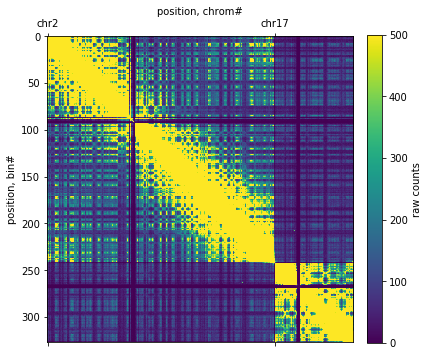

In [7]:
f, ax = plt.subplots(
    figsize=(6,6))
im = ax.matshow((clr.matrix(balance=False)[:]),vmax=500); 
plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts');
plt.xticks(chromstarts,clr.chromnames);
plt.xlabel('position, chrom#')
plt.ylabel('position, bin#')
ax = plt.gca()
ax.xaxis.set_label_position('top')

### Plotting subregions

Below, we fetch and plot an individual chromosome (left) and a region of a chromosome (right) using `clr.fetch()`

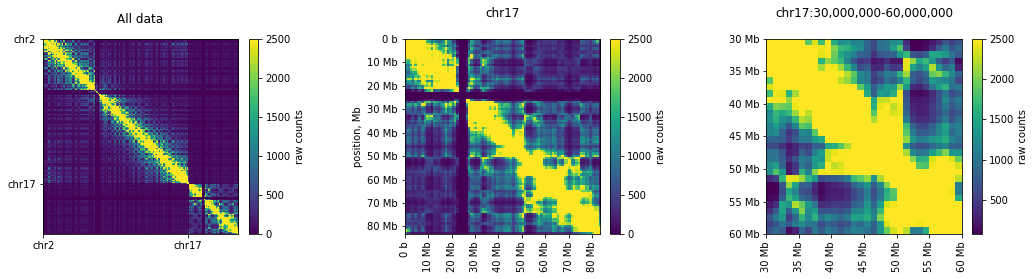

In [26]:
# to plot ticks in terms of megabases we use the EngFormatter 
# https://matplotlib.org/gallery/api/engineering_formatter.html
from matplotlib.ticker import EngFormatter

f, axs = plt.subplots(
    figsize=(15,4),
    ncols=3)
bp_formatter = EngFormatter('b')

ax = axs[0]
im = ax.matshow(clr.matrix(balance=False)[:], vmax=2500); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('chr17'),
    vmax=2500, 
    extent=(0,clr.chromsizes['chr17'], clr.chromsizes['chr17'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('chr17', y=1.08)
ax.set_ylabel('position, Mb')
ax.tick_params(axis='x',rotation=90)
ax.yaxis.set_major_formatter(bp_formatter)
ax.xaxis.set_major_formatter(bp_formatter)
ax.xaxis.tick_bottom()

ax = axs[2]
start, end = 30_000_000, 60_000_000
region = ('chr17', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    vmax=2500, 
    extent=(start, end, end, start)
); 
ax.set_title(f'chr17:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.tick_params(axis='x',rotation=90)
ax.yaxis.set_major_formatter(bp_formatter)
ax.xaxis.set_major_formatter(bp_formatter)
ax.xaxis.tick_bottom()
plt.tight_layout()

### Logarithmic color scale

Since C data has a high dynamic range, we often plot the data in log-scale. This enables simultaneous visualization of features near and far from the diagonal in a consistent colorscale. Note that regions with no reported counts are evident as white stripes at both centromeres. This occurs because reads are not uniquely mapped to these highly-repetitive regions. These regions are masked before [matrix balancing](#balancing).

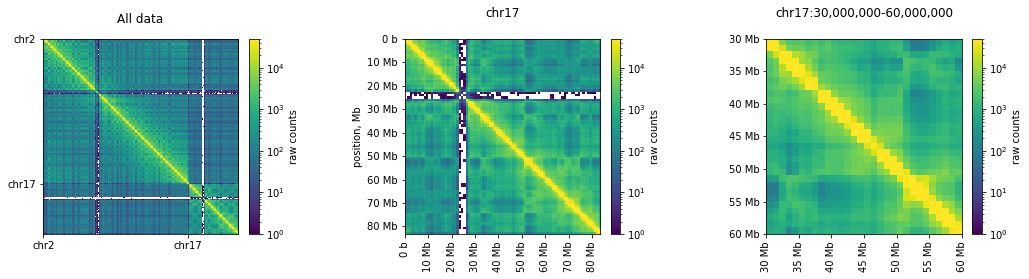

In [36]:
# plot heatmaps at megabase resolution with 3 levels of zoom in log-scale with a consistent colormap#
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(15,4),
    ncols=3)
bp_formatter = EngFormatter('b')
norm = LogNorm(vmax=50_000)

ax = axs[0]
im = ax.matshow(
    clr.matrix(balance=False)[:], 
    norm=norm,
) 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('chr17'),
    norm=norm,
    extent=(0,clr.chromsizes['chr17'], clr.chromsizes['chr17'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('chr17', y=1.08)
ax.set_ylabel('position, Mb')
ax.tick_params(axis='x',rotation=90)
ax.yaxis.set_major_formatter(bp_formatter)
ax.xaxis.set_major_formatter(bp_formatter)
ax.xaxis.tick_bottom()

ax = axs[2]
start, end = 30_000_000, 60_000_000
region = ('chr17', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    norm=norm,
    extent=(start, end, end, start)
); 
ax.set_title(f'chr17:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.tick_params(axis='x',rotation=90)
ax.yaxis.set_major_formatter(bp_formatter)
ax.xaxis.set_major_formatter(bp_formatter)
ax.xaxis.tick_bottom()
plt.tight_layout()

### Colormaps

link to meme image ?

`cooltools.lib.plotting` registers a set of colormaps that are useful for visualizing C data.
In particular, the `fall` colormap (inspired by [colorbrewer](https://colorbrewer2.org/#type=sequential&scheme=YlOrRd&n=9)) offers a high dynamic range, linear, option for visualizing Hi-C matrices. This often displays features more clearly than red colormaps.


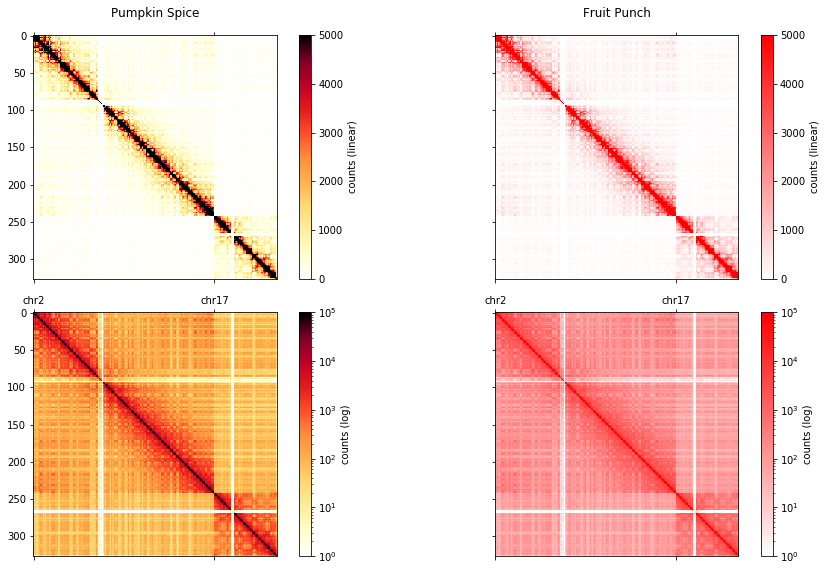

In [118]:
### plot the corrected data in fall heatmap ###
import cooltools.lib.plotting

vmax = 5000
norm = LogNorm(vmin=1, vmax=100_000)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

f, axs = plt.subplots(
    figsize=(15, 8),
    nrows=2, 
    ncols=2,
    sharex=True, sharey=True)

ax = axs[0, 0]
ax.set_title('Pumpkin Spice')
im = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[0, 1]
ax.set_title('Fruit Punch')
im3 = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap=fruitpunch); 
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 0]
im = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 1]
im3 = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap=fruitpunch); 
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

plt.tight_layout()

The utility of fall colormaps becomes more noticeable at higher resolutions and higher degrees of zoom.

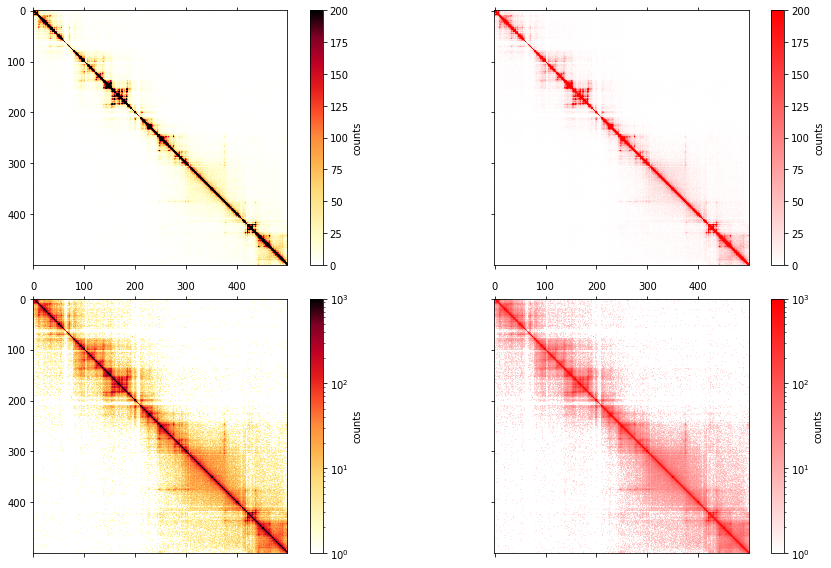

In [80]:
### plot the corrected data in fall heatmap ###
import cooltools.lib.plotting
clr_10kb = cooler.Cooler('./test.mcool::resolutions/10000')

region = 'chr17:30,000,000-35,000,000'
vmax = np.log10(1000)
norm = LogNorm(vmin=1, vmax=1000)

f, axs = plt.subplots(
    figsize=(15, 8),
    nrows=2, 
    ncols=2,
    sharex=True, 
    sharey=True
)

ax = axs[0, 0]
im = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap='fall',
    vmax=200,
); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts');

ax = axs[0, 1]
im2 = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch, 
    vmax=200
); 
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts');

ax = axs[1, 0]
im = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap='fall',
    norm=norm,
); 
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='counts');

ax = axs[1, 1]
im2 = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch, 
    norm=norm
); 
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts');


plt.tight_layout()


In [76]:
#from mpl_toolkits.axes_grid import ImageGrid

# Balancing

When `(balance=True)` is passed to cooler.matrix(), this applies correction weights calculated from matrix balancing. Matrix balancing (also called iterative correction and KR normalization) removes multiplicative biases, which constitute the majority of known biases, from C data.
By default, the rows & columns of the matrix are  normalized to sum to one (note that the colormap scale differs after balancing). Biases, also called weights for normalization, are stored in the bin table given by `clr.bins()`.

Before balancing, cooler also applies filters to remove low-coverage bins (note that peri-centromeric bins are completely removed in the normalized data). Filtered bins are stored as `np.nan` in the weights. 

Matrices appear visually smoother after removal of biases. Smoother matrices are expected for chromosomes, as adjacent regions along a chromosome are connected and should only slowly vary in their contact frequencies with other regions. 


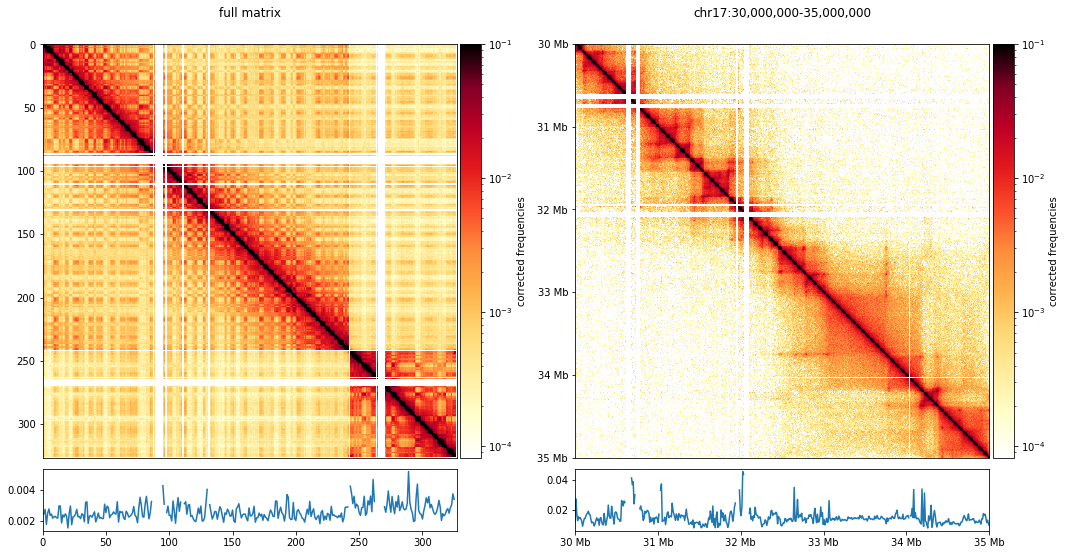

In [114]:
### plot the corrected data in logscale ###
from mpl_toolkits.axes_grid import make_axes_locatable

f, axs = plt.subplots(
    figsize=(15, 10),
    ncols=2,
)

norm = LogNorm(vmax=0.1)

ax = axs[0]
im = ax.matshow(
    clr.matrix()[:], 
    norm=norm,  
    cmap='fall'
); 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_title('full matrix')
ax.xaxis.set_visible(False)

ax = divider.append_axes("bottom", size="15%", pad=0.15, sharex=axs[0])
weights = clr.bins()[:]['weight'].values
ax.plot(weights)
ax.set_xlim([0, len(clr.bins()[:])])


start = 30_000_000
end = 35_000_000
region = ('chr17', start, end)

ax = axs[1]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.matshow(
    clr_10kb.matrix().fetch(region), 
    norm=norm,  
    cmap='fall',
    extent=(start, end, end, start)
); 
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04, label='corrected frequencies');
ax.set_title(f'chr17:{start:,}-{end:,}')
ax.yaxis.set_major_formatter(bp_formatter)
ax.xaxis.set_visible(False)

ax = divider.append_axes("bottom", size="15%", pad=0.15, sharex=axs[1])
weights = clr_10kb.bins().fetch(region)['weight'].values
ax.plot(
    np.linspace(start, end, len(weights)),
    weights
)
ax.xaxis.set_major_formatter(bp_formatter)
ax.set_xlim(start, end);

plt.tight_layout()

<h2 id="coverage">Coverage</h2>

Contact matrices often display varible tendency to make contacts within versus between chromosomes. 
This can be calculated in cooltools with `cooltools.coverage.get_coverage` and is often plotted as a ratio of (cis_coverage/total_coverage).

Text(0,0.5,'coverage ratio')

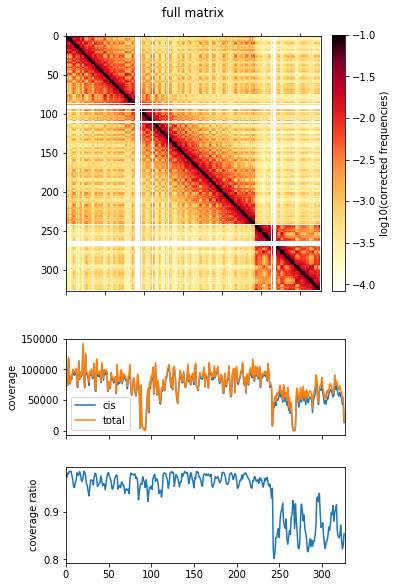

In [209]:
from cooltools.coverage import  get_coverage
cis_coverage, tot_coverage = get_coverage(clr)

f, axs = plt.subplots(
    figsize=(5,10),
    nrows=3, 
    ncols=1,
    gridspec_kw={'height_ratios':[6,2,2]}, 
    sharex=True, sharey=False)


ax= axs[0]
im = ax.matshow(np.log10(clr.matrix()[:]), vmax=-1,  cmap='fall'); 
plt.colorbar(im,ax=ax ,fraction=0.046, pad=0.04, label='log10(corrected frequencies)');
ax.set_title('full matrix')

ax=axs[1]
ax.plot( cis_coverage, label='cis')
ax.plot( tot_coverage, label='total')
ax.set_xlim([0, len(clr.bins()[:])])
ax.legend()
ax.set_ylabel('coverage')
#ax.set_ylim([0,.006])

ax=axs[2]
ax.plot( cis_coverage/ tot_coverage)
ax.set_xlim([0, len(clr.bins()[:])])
ax.set_ylabel('coverage ratio')

#### Smoothing & Interpolation
When working with C data at high resolution, it is often useful to smooth matrices. cooltools provides a method, `adaptive_coarsegrain`, which adaptively smoothing corrected matrices based on the number of counts in raw matrices. For visualization it is also often useful to interpolate over filtered out bins. 

/Users/geofffudenberg/repositories/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


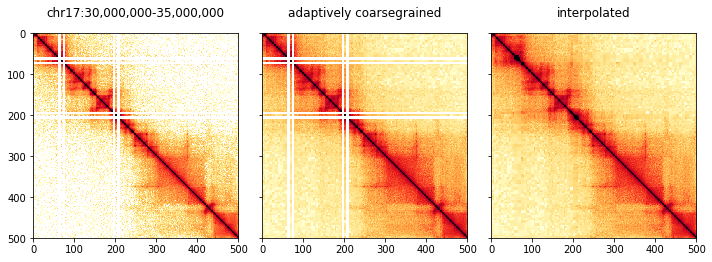

In [232]:
from cooltools.lib.numutils import  adaptive_coarsegrain, interp_nan

clr_1kb = cooler.Cooler('./test.mcool::resolutions/10000')
region = 'chr17:30,000,000-35,000,000'
vmax = -1

cg = adaptive_coarsegrain(clr_1kb.matrix(balance=True).fetch(region),
                              clr_1kb.matrix(balance=False).fetch(region),
                              cutoff=2, max_levels=8)

cgi = interp_nan(cg)

f, axs = plt.subplots(
    figsize=(10,10),
    nrows=1, 
    ncols=3,
    sharex=True, sharey=True)

ax=  axs[0]
im = ax.matshow(np.log10(clr_1kb.matrix(balance=True).fetch(region)),cmap='fall',vmax=vmax); 
#plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='log10(corrected frequencies)');
ax.set_title(region)
ax.xaxis.set_ticks_position('bottom')

ax=  axs[1]
im2 = ax.matshow(np.log10(cg),cmap='fall', vmax=vmax); 
#plt.colorbar(im2 ,ax=ax,fraction=0.046, pad=0.04, label='log10(corrected frequencies)');
ax.set_title(f'adaptively coarsegrained')
ax.xaxis.set_ticks_position('bottom')

ax=  axs[2]
im2 = ax.matshow(np.log10(cgi),cmap='fall', vmax=vmax); 
#plt.colorbar(im2 ,ax=ax,fraction=0.046, pad=0.04, label='log10(corrected frequencies)');
ax.set_title(f'interpolated')
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()

In [ ]:
### todo: 
# - translocations, yeast, etc..
# - higlass